In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster
from vincenty import vincenty
from h3 import h3
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import folium
import branca.colormap as cm
from geojson.feature import *
import json
from IPython.display import Image, display
import calendar
from tqdm import tqdm


In [2]:
def counts_by_hexagon(df, resolution):
    """
    Use h3.geo_to_h3 to index each data point into the spatial index of the specified resolution.
    Use h3.h3_to_geo_boundary to obtain the geometries of these hexagons
    
    Ex counts_by_hexagon(data, 9)
    """
    df = df[["lat","lng"]]
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["lat"], row["lng"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(h3_address=x,geo_json=True)]
                                                            }
                                                        )
    
    return df_aggreg

def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    """
    Produce the GeoJSON for a dataframe that has a geometry column in geojson 
    format already, along with the columns hex_id and value
    
    Ex counts_by_hexagon(data)
    """    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result


def choropleth_map(df_aggreg, border_color = 'black', fill_opacity = 0.7, initial_map = None, with_legend = False,
                   kind = "linear"):
    
    """
    Creates choropleth maps given the aggregated data.
    """    
    #colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])
    
    if initial_map is None:
        initial_map = Map(location= [40.718728, -73.943802], zoom_start=12, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['green','yellow','red'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg)
    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)
    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map

def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):
    """
    Scatter plot function for h3 indexed objects
    """    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

In [3]:
%time

df_list = [] # list to hold the batch dataframe

TRAIN_PATH = 'filtered.csv'

# Peep at the training file header
df_tmp = pd.read_csv(TRAIN_PATH, nrows=5)
print(df_tmp.head())

df_tmp.info()

# Set columns to most suitable type to optimize for memory usage
#traintypes = {'tpep_pickup_datetime': 'str', 
#              'PULocationID': 'float16',
#              'DOLocationID': 'float16'}


traintypes = {'tpep_pickup_datetime': 'str', 
              'pickup_latitude': 'float32',
              'pickup_longitude': 'float32'}
cols = traintypes.keys()

#cols = list(traintypes.keys())
chunksize = 1_000_000 # 5 million rows at one go. Or try 10 million

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH,  dtype=traintypes, chunksize=chunksize, usecols=cols)):#, parse_dates=[0,1])): #usecols=cols,
     
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Using parse_dates would be much slower!
    #df_chunk['tpep_pickup_datetime'] = df_chunk['tpep_pickup_datetime'].str.slice(0, 16)
    #df_chunk['tpep_pickup_datetime'] = pd.to_datetime(df_chunk['tpep_pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    # Can process each chunk of dataframe here
    # clean_data(), feature_engineer(),fit()
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk)

Wall time: 0 ns
   Unnamed: 0       tpep_pickup_datetime  pickup_latitude  pickup_longitude
0           0  2016-04-01 00:00:00+00:00        40.758495        -73.976883
1           1  2016-04-01 00:00:00+00:00        40.757294        -73.985207
2           2  2016-04-01 00:00:00+00:00        40.758869        -73.979202
3           3  2016-04-01 00:00:00+00:00        40.767723        -73.984856
4           4  2016-04-01 00:00:00+00:00        40.769470        -73.863739
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
Unnamed: 0              5 non-null int64
tpep_pickup_datetime    5 non-null object
pickup_latitude         5 non-null float64
pickup_longitude        5 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 180.0+ bytes


12it [00:13,  1.13s/it]


In [7]:
traintypes.keys()

dict_keys(['Pickup_DateTime', 'pickup_latitude', 'pickup_longitude'])

In [4]:
%time

# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
train_df.info()

Wall time: 0 ns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934338 entries, 0 to 11934337
Data columns (total 3 columns):
tpep_pickup_datetime    object
pickup_latitude         float32
pickup_longitude        float32
dtypes: float32(2), object(1)
memory usage: 136.6+ MB


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934338 entries, 0 to 11934337
Data columns (total 3 columns):
tpep_pickup_datetime    object
pickup_latitude         float32
pickup_longitude        float32
dtypes: float32(2), object(1)
memory usage: 136.6+ MB


In [29]:
train_df.describe()

,pickup_latitude,pickup_longitude
count,1.193434e+07,1.193434e+07
mean,3.755972e+01,-6.666102e+01
std,5.353970e+00,1.033484e+01
min,0.000000e+00,-8.467648e+01
25%,4.073587e+01,-7.399178e+01
50%,4.075333e+01,-7.398151e+01
75%,4.076818e+01,-7.396642e+01
max,5.893977e+01,0.000000e+00


In [5]:
tripsDB = train_df
tripsDB.head()

,tpep_pickup_datetime,pickup_latitude,pickup_longitude
0,2016-04-01 00:00:00+00:00,40.758495,-73.976883
1,2016-04-01 00:00:00+00:00,40.757294,-73.985207
2,2016-04-01 00:00:00+00:00,40.758869,-73.979202
3,2016-04-01 00:00:00+00:00,40.767723,-73.984856
4,2016-04-01 00:00:00+00:00,40.769470,-73.863739


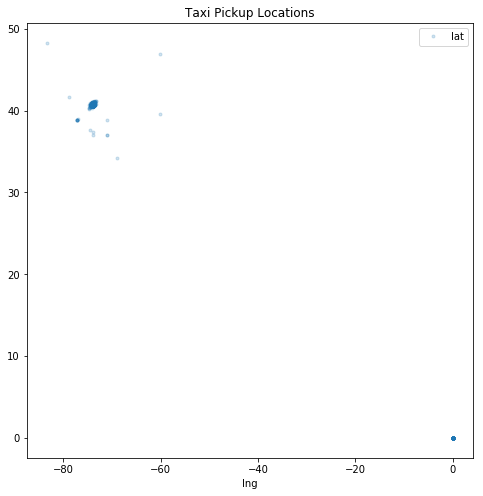

In [25]:
# Keep only location data
dfgeo = tripsDB[['tpep_pickup_datetime','pickup_latitude','pickup_longitude']].reset_index(drop=True)

# Simplify column names
dfgeo.columns = ['dt','lat','lng']
test = dfgeo.sample(frac=0.05, replace=False, random_state=1)
test.plot(x='lng',y='lat',style='.',alpha=0.2,figsize=(8,8));
plt.title('Taxi Pickup Locations');

e:\Anaconda3\envs\mypython3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


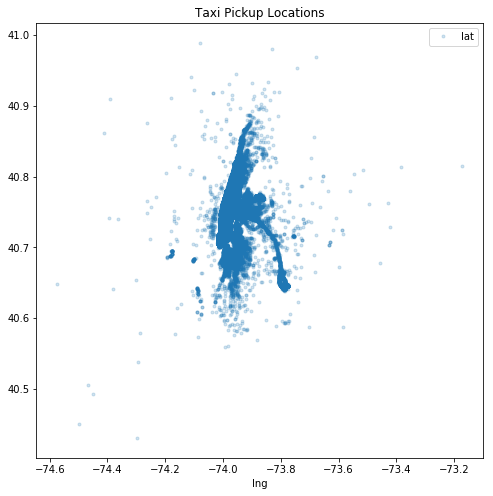

In [26]:
test = test[dfgeo.lat>40.4]
test = test[test.lat<41]
test.plot(x='lng',y='lat',style='.',alpha=0.2,figsize=(8,8));
plt.title('Taxi Pickup Locations');

In [16]:
test.head()

,lat,lng,hex10
4686059,40.78125,-73.9375,8a2a100f2477fff
6762380,40.75000,-74.0000,8a2a10725257fff
491263,40.75000,-74.0000,8a2a10725257fff
6662859,40.71875,-74.0000,8a2a1072c3a7fff
9554767,40.78125,-74.0000,8a2a1008b407fff


In [8]:
dfgeo = test

In [13]:
dfagg.head()

,hex10,cnt,lat,lng
0,8a2a10010427fff,1,40.878171,-73.867219
1,8a2a1001059ffff,1,40.879185,-73.871854
2,8a2a10010b0ffff,1,40.874221,-73.844392
3,8a2a100114affff,1,40.858808,-73.855477
4,8a2a10011797fff,1,40.854306,-73.854088


In [16]:
df_aggreg = counts_by_hexagon(df = dfgeo, resolution = 9)
df_aggreg.sort_values(by = "value", ascending = False, inplace = True)
df_aggreg.head(5)
hexmap = choropleth_map(df_aggreg = df_aggreg, with_legend = True)
hexmap.save('source/saved.html')
hexmap

In [21]:
df_aggreg_9 = counts_by_hexagon(df = dfgeo, resolution = 9)
df_aggreg_8 = counts_by_hexagon(df = dfgeo, resolution = 8)
df_aggreg_7 = counts_by_hexagon(df = dfgeo, resolution = 7)
df_aggreg_6 = counts_by_hexagon(df = dfgeo, resolution =6)


hexmap9 = choropleth_map(df_aggreg = df_aggreg_9,with_legend = False)
hexmap8 = choropleth_map(df_aggreg = df_aggreg_8, initial_map = hexmap9, with_legend = False)
hexmap7 = choropleth_map(df_aggreg = df_aggreg_7, initial_map = hexmap8 , with_legend = False)
hexmap6 = choropleth_map(df_aggreg = df_aggreg_6, initial_map = hexmap7, with_legend = False)

folium.map.LayerControl('bottomright', collapsed=False).add_to(hexmap6)

hexmap6.save('source/choropleth_multiple_res.html')
hexmap6